In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn import preprocessing
import fm2p
from sklearn.metrics import r2_score

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
# Goal: predict the current pupil position using the spike rate of one neuron.
# Maybe try doing it with the entire population?

In [4]:
preproc_path = r'K:\Mini2P\250306_DMM_DMM038_pillar\fm2\250306_DMM_DMM038_fm_2_preproc.h5'
data = fm2p.read_h5(preproc_path)

In [5]:
goodcells = [0,4,5,7,8,10,11,12,14,17,19,20,22,23,27,35,38,
             47,48,49,53,55,56,61,75,78,82,83,84,97,98]

In [39]:
# Spike rate
X = data['s2p_spks'].copy()#[goodcells,:]

# Pupil position
y = data['pupil_from_head'].copy()

# Anywhere that y has a NaN, drop both y and X
tokeep = ~np.isnan(y)
X = X[:, tokeep].T
y = y[tokeep]
y = y[np.newaxis, :]
y = y.T

scalerX = preprocessing.StandardScaler().fit(X)
X_scaled = scalerX.transform(X)
scalerY = preprocessing.StandardScaler().fit(y)
y_scaled = scalerY.transform(y)

splitind = int((np.size(X_scaled,0)/4)*3)
X_train = X_scaled[:splitind, :]
y_train = y_scaled[:splitind, :]
X_test = X_scaled[splitind:, :]
y_test = y_scaled[splitind:, :]

In [55]:
# add time lag features
X_lagfeat = np.zeros([np.size(X_train,0), np.size(X_train,1)*5]) * np.nan
for i in range(np.size(X_train,0)): # timestamps
    for j in range(np.size(X_train,1)): # cell
        X_lagfeat[i,j] = X_train[i,j]
        X_lagfeat[i,np.size(X_train,1)+j] = X_train[i-1,j]
        X_lagfeat[i,(np.size(X_train,1)*2)+j] = X_train[i-2,j]
        X_lagfeat[i,(np.size(X_train,1)*3)+j] = X_train[i-3,j]
        X_lagfeat[i,(np.size(X_train,1)*4)+j] = X_train[i-4,j]

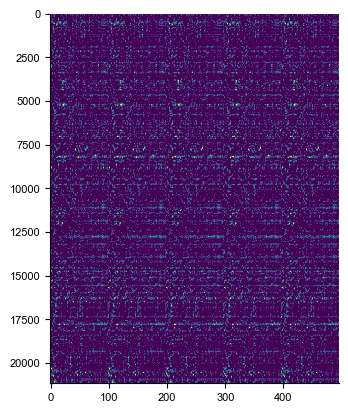

In [56]:
plt.imshow(X_lagfeat, aspect=0.03, vmin=0, vmax=1)

In [57]:
from sklearn.linear_model import ARDRegression

In [58]:
model = sklearn.linear_model.ARDRegression(
    compute_score=True,
    verbose=True
    ).fit(
        X_train,
        y_train
    )

Converged after 4 iterations


In [59]:
y_hat = model.predict(X_test)

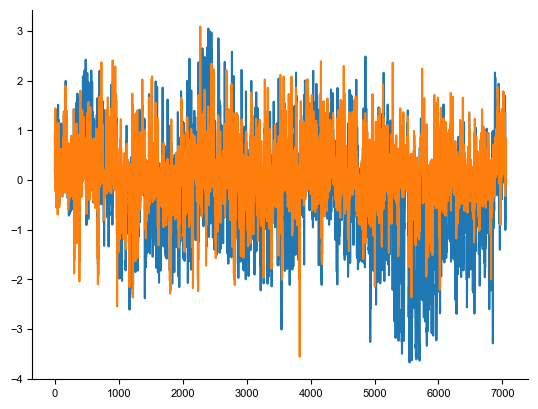

In [60]:
plt.plot(y_test)
plt.plot(y_hat)

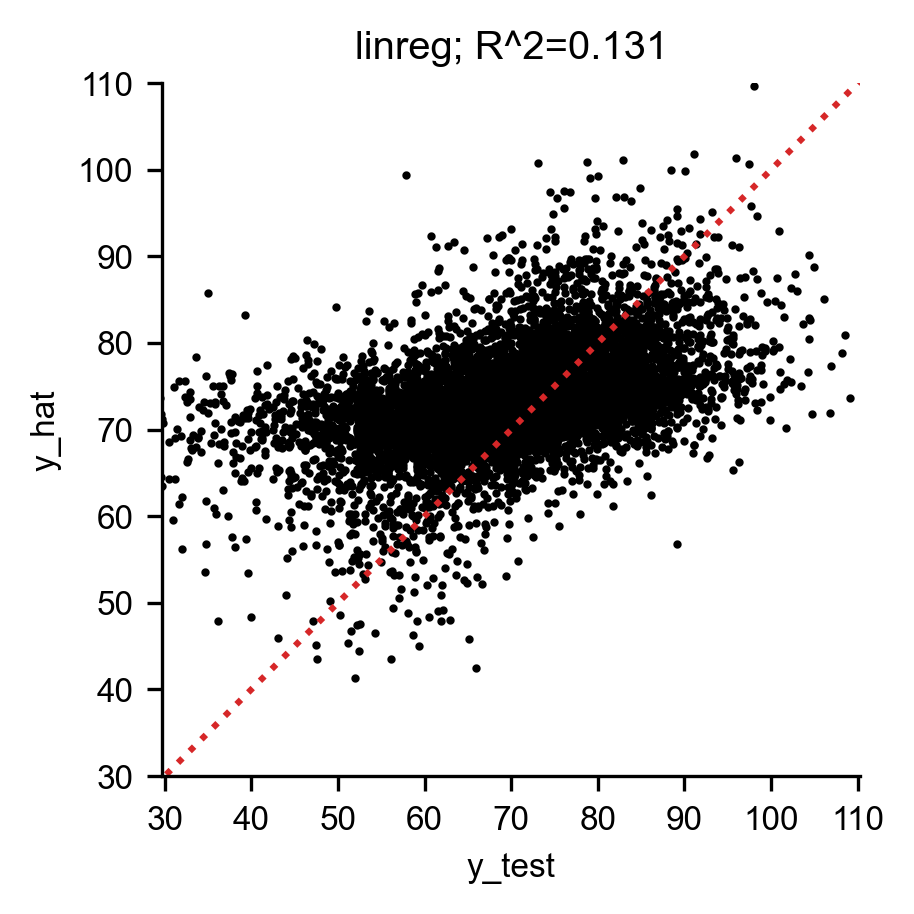

In [61]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat[:,np.newaxis]))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat[:,np.newaxis]),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([30,110])
plt.ylim([30,110])
plt.title('linreg; R^2={:.3}'.format(r2))
_ = plt.xticks(np.arange(30,120,10))

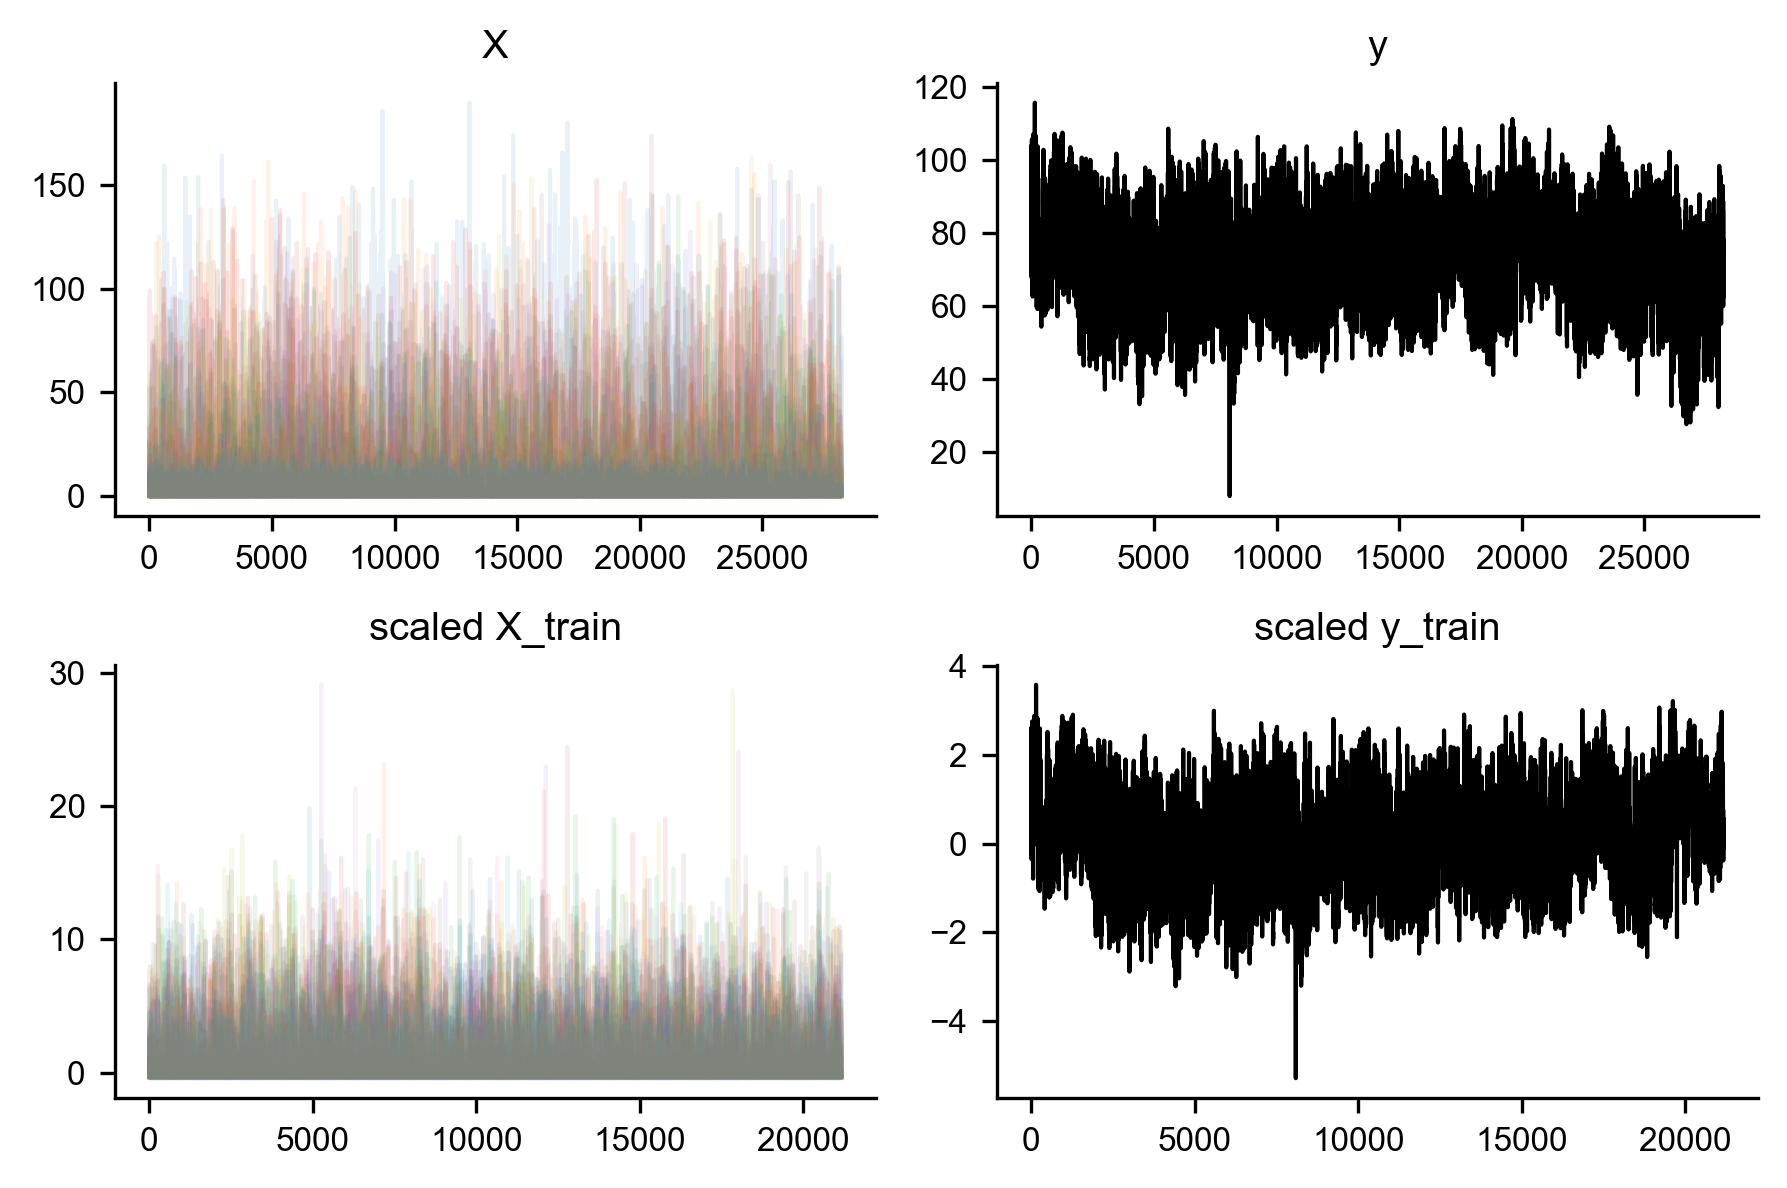

In [7]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(6,4), dpi=300)
ax1.plot(X, lw=1, alpha=0.1)
ax2.plot(y, 'k', lw=1)
ax3.plot(X_train, lw=1, alpha=0.1)
ax4.plot(y_train, 'k', lw=1)
ax1.set_title('X')
ax2.set_title('y')
ax3.set_title('scaled X_train')
ax4.set_title('scaled y_train')
fig.tight_layout()

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21163, 31), (21163, 1), (7055, 31), (7055, 1))

In [9]:
reg = sklearn.linear_model.LinearRegression(
    fit_intercept=True
).fit(X_train, y_train)
y_hat = reg.predict(X_test)

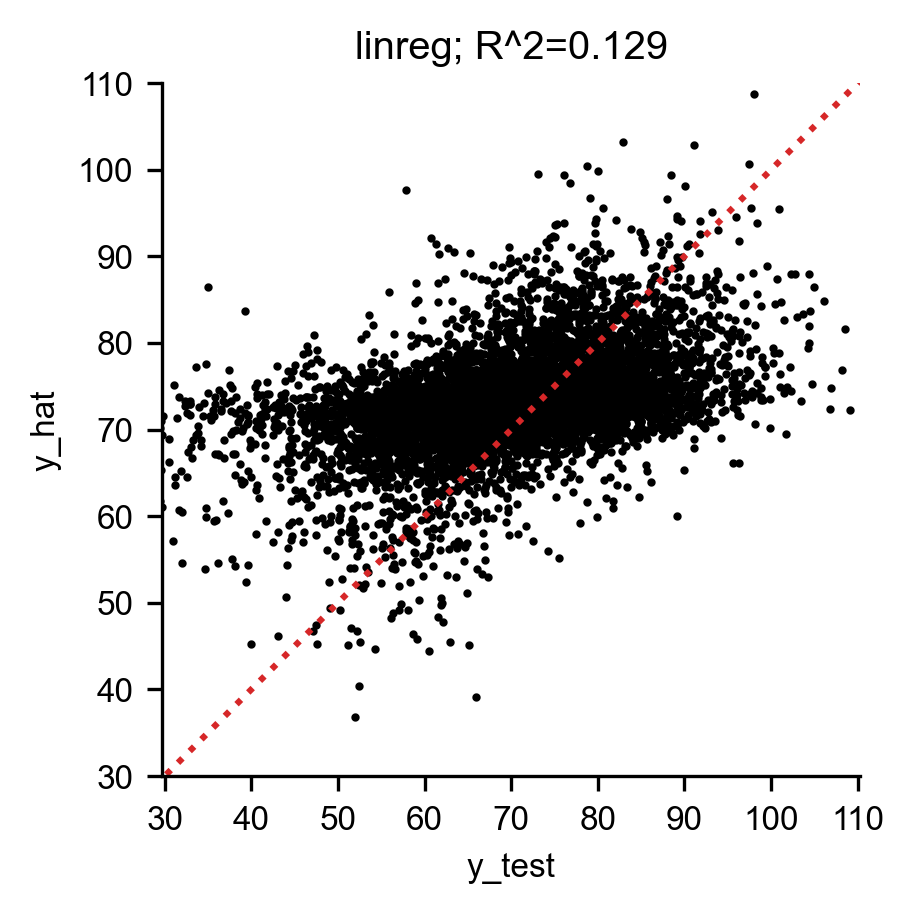

In [10]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([30,110])
plt.ylim([30,110])
plt.title('linreg; R^2={:.3}'.format(r2))
_ = plt.xticks(np.arange(30,120,10))

In [195]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [197]:
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X_train, y_train)
y_hat1 = model.predict(X_test)

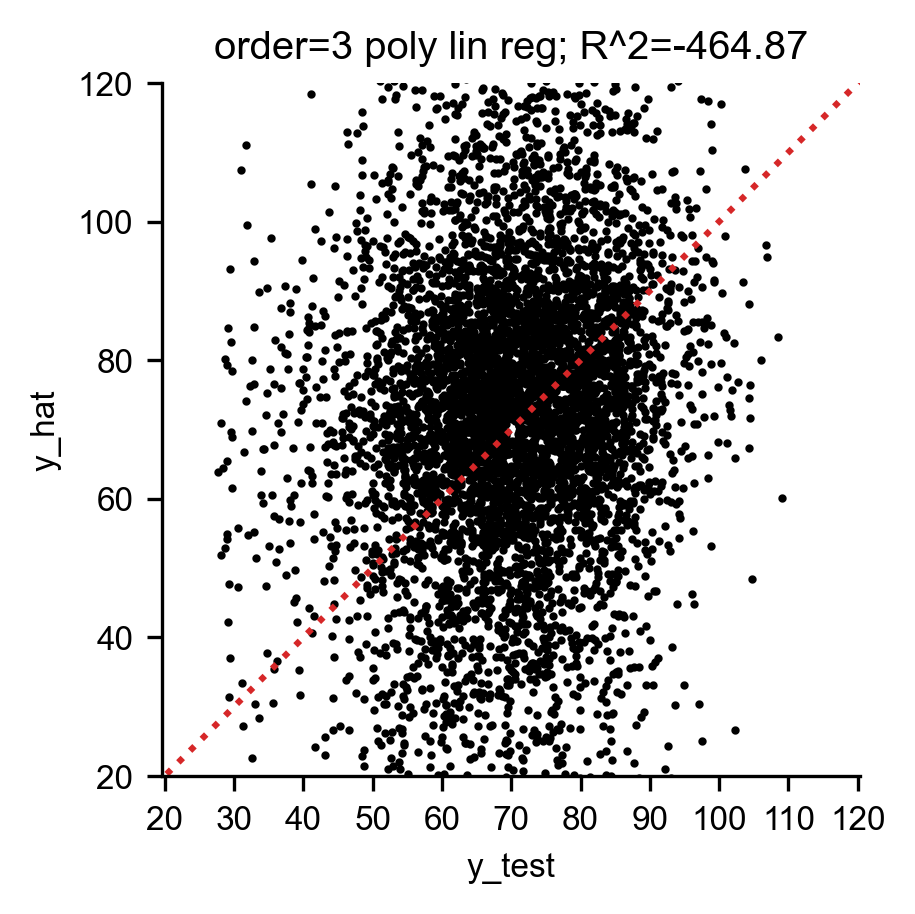

In [225]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat1))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat1),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([20,120])
plt.ylim([20,120])
plt.title('order=3 poly lin reg; R^2={:.5}'.format(r2))
_ = plt.xticks(np.arange(20,130,10))

In [208]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X_train, y_train)
y_hat2 = model.predict(X_test)

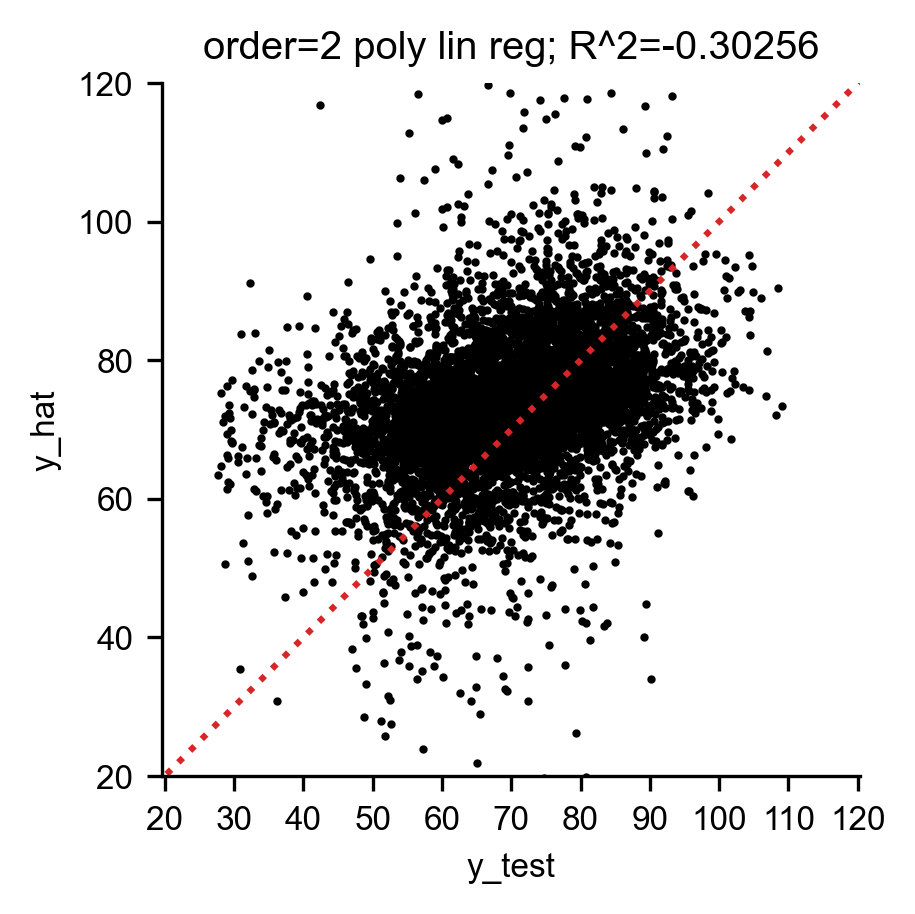

In [211]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat2))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat2),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([20,120])
plt.ylim([20,120])
plt.title('order=2 poly lin reg; R^2={:.5}'.format(r2))
_ = plt.xticks(np.arange(20,130,10))

In [212]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_hat3 = model.predict(X_test)

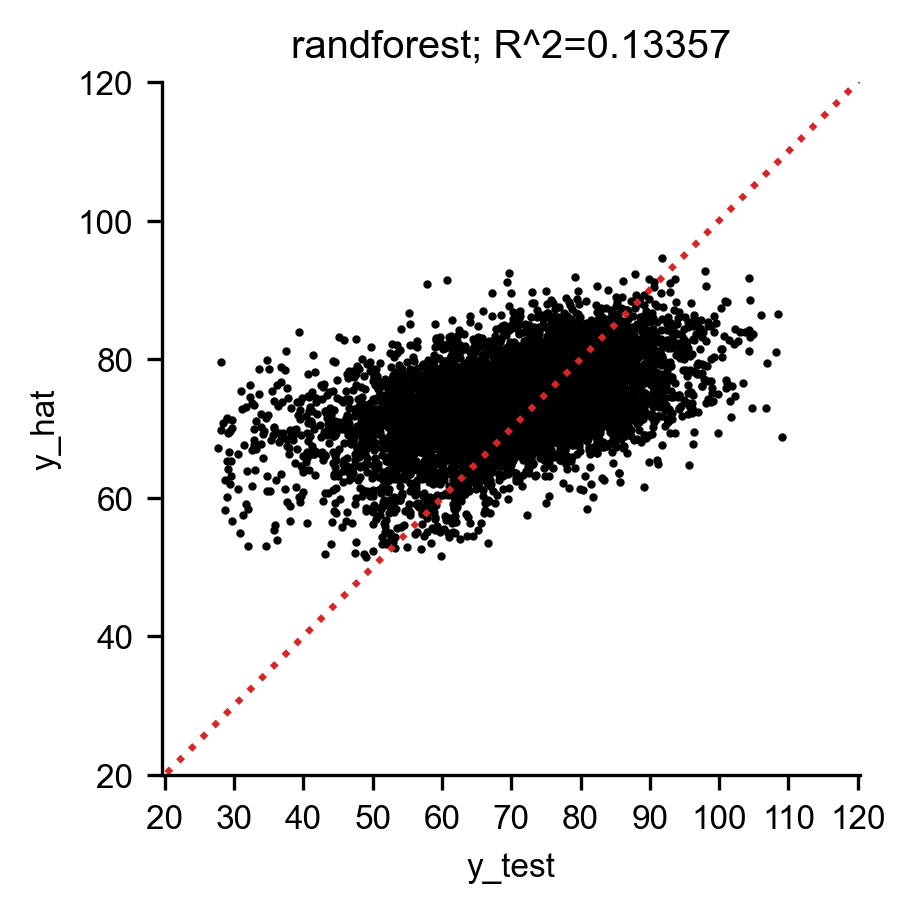

In [223]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat3[:,np.newaxis]))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat3[:,np.newaxis]),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([20,120])
plt.ylim([20,120])
plt.title('randforest; R^2={:.5}'.format(r2))
_ = plt.xticks(np.arange(20,130,10))

In [226]:
from sklearn.neural_network import MLPRegressor

In [230]:
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=1000)
model.fit(X_train, y_train)
y_hat4 = model.predict(X_test)

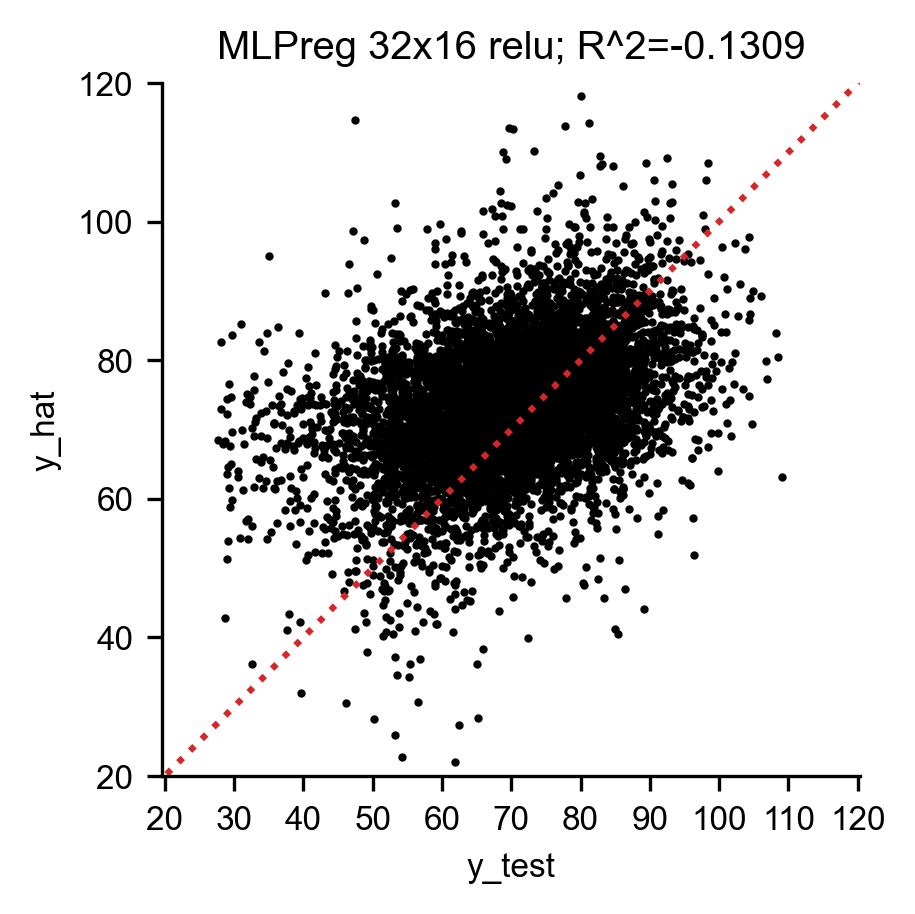

In [231]:
r2 = r2_score(scalerY.inverse_transform(y_test), scalerY.inverse_transform(y_hat4[:,np.newaxis]))
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(
    scalerY.inverse_transform(y_test),
    scalerY.inverse_transform(y_hat4[:,np.newaxis]),
    color='k', s=1
)
plt.plot([0,130],[0,130], ':', color='tab:red')
plt.xlabel('y_test')
plt.ylabel('y_hat')
plt.axis('equal')
plt.xlim([20,120])
plt.ylim([20,120])
plt.title('MLPreg 32x16 relu; R^2={:.5}'.format(r2))
_ = plt.xticks(np.arange(20,130,10))

In [118]:
y_hat_scaled = scalerY.inverse_transform(y_hat)

In [119]:
np.min(y_hat_scaled), np.max(y_hat_scaled), np.median(y_hat_scaled)

(72.97737, 76.0465, 72.97737)

Text(0, 0.5, 'y_hat')

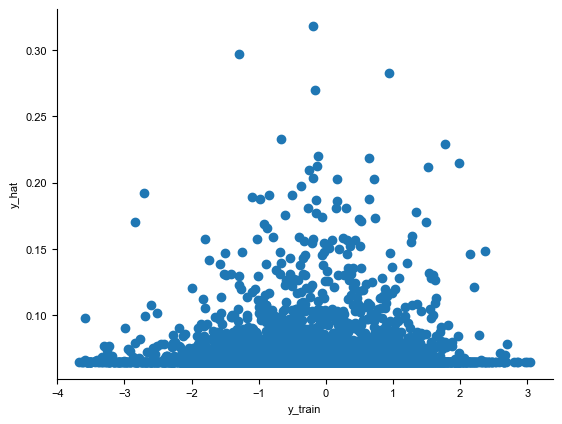

In [120]:
plt.scatter(y_test, y_hat)
plt.xlabel('y_train')
plt.ylabel('y_hat')

In [122]:
print(reg.coef_, reg.intercept_)

[[0.01353677]] [0.06917883]


(array([2.1938e+04, 7.1200e+02, 1.0010e+03, 1.2310e+03, 1.3810e+03,
        9.5400e+02, 5.5500e+02, 2.8900e+02, 1.3600e+02, 2.1000e+01]),
 array([0.        , 0.51210344, 1.02420688, 1.53631043, 2.04841375,
        2.56051731, 3.07262087, 3.58472419, 4.09682751, 4.60893106,
        5.12103462]),
 <BarContainer object of 10 artists>)

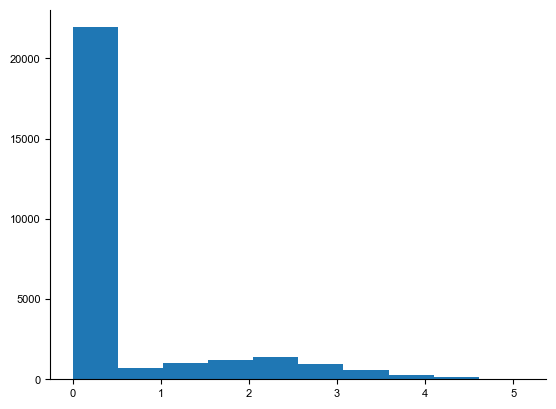

In [124]:
plt.hist(np.log1p(X))

In [107]:
# reg = sklearn.linear_model.Ridge(alpha=.5).fit(X_train, y_train)
# y_hat = reg.predict(X_test)

In [108]:
# plt.hist(y_train/np.max(np.abs(y_train)))

In [109]:
# usey = y_train+np.min(y_train)
# usey = usey/np.max(usey)
# reg = sklearn.linear_model.TweedieRegressor(
#     power=2,
#     link='log'
# ).fit(X_train, usey)
# y_hat = reg.predict(X_test)

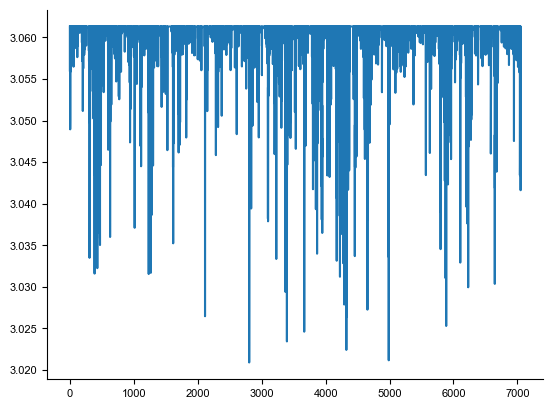

In [87]:
plt.plot(y_hat)

(array([3.000e+00, 1.600e+01, 1.320e+02, 8.840e+02, 4.667e+03, 8.897e+03,
        8.460e+03, 4.213e+03, 8.950e+02, 5.100e+01]),
 array([  7.9353739 ,  18.71358834,  29.49180278,  40.27001722,
         51.04823166,  61.8264461 ,  72.60466054,  83.38287497,
         94.16108941, 104.93930385, 115.71751829]),
 <BarContainer object of 10 artists>)

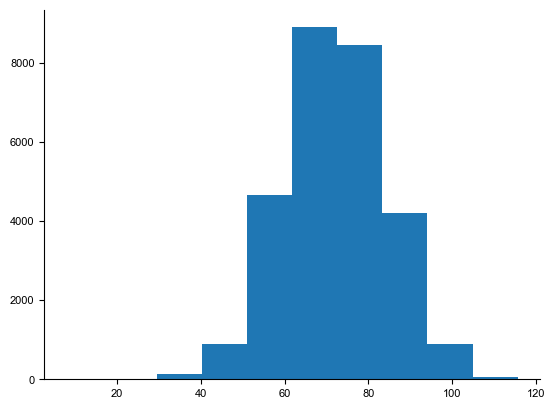

In [89]:
plt.hist(y)